In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.path import Path


In [93]:
class SankeyNode:
    '''
    This class defines and draws a single node in the sankey diagram. It shouldn't need to be created
    by the end user, but one may want to edit some properties after creation.

    For example, if you wanted to edit the label format of a single node to have more decimals:
        s = Sankey(flows)
        node = s.find_node(node_name)[0]
        node.label_format = '{label} {value:,.2f}'
    '''

    def __init__(self, x, y, width, height, name, 
                    value=0, label='', label_format='{label}\n{value:,.0f}', label_pos='left', label_pad_x=0.01, label_opts=dict(fontsize=14), 
                    align_y='top', color='#FF33AA',
                    artist='rectangle', **kwargs):
        '''
        @param x : left edge, typically the flow level, as a 0-indexed integer. 1 = distance between nodes 
        @param y : bottom edge, between [0, 1]
        @param width : 1 = distance between nodes
        @param height : total extent of axis is 1
        @param name : aunique name to refer to this node
        @param value : the value of this node
        @param align_y : how to align the flows that enter/exit the node. Options: {'top'}
        @param color : any matplotlib color specifier
        @param label : alternative name to display. If not label, uses `name`
        @param label_format : format string that can optionally have 'label' and 'value' fields. Set to '' to remove labels
        @param label_pos : position of the label {'left', 'top'}
        @param label_pad_x : padding in x from the node, as fraction of distance between nodes
        @param label_opts : dictionary with additional options for the label. See matplotlib.axis.text() for options
        '''
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.name = name
        self.value = value
        self.label = label or name
        self.label_format = label_format
        self.label_pos = label_pos
        self.label_pad_x = label_pad_x
        self.label_opts = label_opts
        self.artist_type = artist
        self.align_y = align_y
        self.color = color
        self.flow_pad = 0 # vertical padding between flow endpoints
        self.inflows = []
        self.outflows = []
        self.artist = None
        self.text = None


    def get_flow_y(self, i, side='inflows'):
        '''
        Returns the (y_low, y_hi) position of flow i on the given side
        '''
        flows = getattr(self, side)
        if self.align_y == 'top':
            value_scale = self.value / (self.height - self.flow_pad * (len(flows) - 1))
            y1 = self.y + self.height - (np.sum([x.value for x in flows[:i]]) / value_scale + self.flow_pad * i)
            y0 = y1 - flows[i].value / value_scale
            return (y0, y1)
        else:
            raise NotImplementedError("align_y: " + align_y)

    def draw(self, ax):
        # Node
        if self.artist_type == 'rectangle':
            self.artist = mpatches.Rectangle((self.x, self.y), self.width, self.height)
        else:
            raise NotImplementedError("artist: {}".format(self.artist_type))
        self.artist.set_color(self.color)
        self.artist.set_edgecolor(None)
        ax.add_patch(self.artist)

        # Label
        if self.label_format:
            if self.label_pos == 'left':
                x = self.x - self.label_pad_x
                y = self.y + self.height / 2
                ha = 'right'
                va = 'center'
            elif self.label_pos == 'top':
                x = self.x + self.width / 2
                y = self.y + self.height
                ha = 'center'
                va = 'bottom'
            else:
                raise NotImplementedError("label_pos: " + self.label_pos)
            self.text = ax.text(x, y, self.label_format.format(label=self.label, value=self.value), ha=ha, va=va, **self.label_opts)



class SankeyFlow:
    '''
    This class defines and draws a single flow in the sankey diagram. It shouldn't need to be created
    by the end user, but one may want to edit some properties after creation.
    '''

    path_codes = [
        Path.MOVETO, # Top left
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4, # Top right
        Path.LINETO, # Bottom right
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4, # Bottom left
        Path.CLOSEPOLY
    ]

    def __init__(self, src, des, value, curvature = 0.3, color='#AAAAAA66', **kwargs):
        '''
        @param src : the source node
        @param des : the destination node
        @param value : value of the flow
        @param curvature : how curvy the flows are, with 0 = no curve and 1 = maximal curve
        @param color : Any matplotlib color specifier
        '''
        self.value = value
        self.curvature = curvature
        self.color = color
        self.node_pad = 0 # x padding from the node (sometimes they overlap), as fraction of distance between nodes in x
        self.artist = None

        self.src = src
        self.des = des
        self.src_i = len(src.outflows)
        self.des_i = len(des.inflows)
        src.outflows.append(self)
        des.inflows.append(self)


    def draw(self, ax):

        if self.src.artist_type != 'rectangle':
            raise NotImplementedError("artist: {}".format(self.src.artist_type))
        if self.des.artist_type != 'rectangle':
            raise NotImplementedError("artist: {}".format(self.des.artist_type))

        x1 = self.src.x + self.src.width + self.node_pad
        x2 = self.des.x - self.node_pad
        (y1_1, y1_2) = self.src.get_flow_y(self.src_i, 'outflows')
        (y2_1, y2_2) = self.des.get_flow_y(self.des_i, 'inflows')

        if self.curvature == 0:
            self.artist = mpatches.Polygon([
                [x1, y1_2], # top left
                [x2, y2_2], # top right
                [x2, y2_1], # bottom right
                [x1, y1_1], # bottom left
            ])
            self.artist.set_color(self.color)
            self.artist.set_edgecolor(None)
        else:
            poly_x1 = x1 + self.curvature * (x2 - x1)
            poly_x2 = x2 - self.curvature * (x2 - x1)
            path = Path([
                    [x1, y1_2], # top left
                    [poly_x1, y1_2], # top control 1
                    [poly_x2, y2_2], # top control 2
                    [x2, y2_2], # top right
                    [x2, y2_1], # bottom right
                    [poly_x2, y2_1], # bottom control 1
                    [poly_x1, y1_1], # bottom control 2
                    [x1, y1_1], # bottom left
                    [0, 0], # end
                ], SankeyFlow.path_codes)
            self.artist = mpatches.PathPatch(path, facecolor=self.color, linewidth=0)
            self.artist.set_edgecolor(None)
        
        ax.add_patch(self.artist)


class Sankey:
    '''
    This class creates and manages a sankey diagram. The typical workflow is:
        s = Sankey()
        s.sankey(flows, nodes)
        s.draw()
        plt.show()
    '''

    def __init__(self, flows=None, nodes=None, align_y='top', 
                    cmap=plt.cm.tab10, flow_color_mode='dest', flow_color_mode_alpha=0.6, 
                    node_width=0.03, node_pad_y_min=0.01, node_pad_y_max=0.05, **kwargs):
        '''
        @param flows : see Sankey.sankey(). Can optionally input flows here as a shortcut
        @param nodes : see Sankey.sankey(). Can optionally input nodes here as a shortcut
        @param cmap : colormap for default colors
        @param flow_color_mode : {'source', 'dest', 'lesser', 'greater', None}
                    'source', 'dest' : the flows will be colored the same as the source/destination node
                    'lesser', 'greater' : the flows will be colored as the node with the lesser/greater value 
        @param flow_color_mode_alpha : transparency of the flows
        @param node_width : width of the nodes, as fraction of distance between nodes
        @param node_pad_y_min : minimum vertical padding between nodes, as fraction of distance between nodes
        @param node_pad_y_max : maximum vertical padding between nodes, as fraction of distance between nodes
        '''
        self.align_y = align_y
        self.flow_color_mode = flow_color_mode
        self.flow_color_mode_alpha = flow_color_mode_alpha
        self.node_width = node_width
        self.node_pad_y_min = node_pad_y_min
        self.node_pad_y_max = node_pad_y_max
        self.cmap = cmap
        self.nodes = [] # Nested list of SankeyNode, indexed by (node_level, i_node)
        self.flows = [] # List of SankeyFlows

        if flows or nodes:
            self.sankey(flows, nodes)

    def find_node(self, name):
        '''
        Finds the node with the given name and returns it and its level in the current diagram (node, level)
        '''
        for level,node_level in enumerate(self.nodes):
            for node in node_level:
                if node.name == name:
                    return (node, level)
        return (None, None)

    
    def _level_node_padding(self, level_value, level_n):
        '''
        @param level_value : Total value in this level, AFTER scaling
        @returns the padding to use in this level
        '''
        if level_n < 2:
            return 0
        max_padding = (1 - level_value) / (level_n - 1)
        return max(self.node_pad_y_min, min(max_padding, self.node_pad_y_max))


    def sankey(self, flows, nodes):
        '''
        @param flows : A list of flows as (source_name, dest_name, value) or (source_name, dest_name, value, opts),
                       where opts is a dictionary containing arguments to SankeyFlow(). opts may also contain key flow_color_mode with 
                       the same meaning as in Sankey(), but applied only to this flow. 
        @param nodes : A list of node levels, from sources to destinations. In each level, a list of nodes as (name, value) or (name, value, opts),
                       where opts is a dictionary containing arguments to SankeyNode().
        '''
        # Get scaling
        _total_value_per_level = [sum(node[1] for node in level) for level in nodes]
        max_level_value = np.max(_total_value_per_level)
        max_level_n = np.max([len(level) for level,val in zip(nodes,_total_value_per_level) if max_level_value - val < 1e-5])
        value_scale = max_level_value / (1 - self.node_pad_y_min * (max_level_n - 1))

        # Nodes
        self.nodes = []
        i_color = 0 # for automatic coloring
        for level,node_level in enumerate(nodes):
            arr = [] # nodes in this level
            node_pad_y = self._level_node_padding(_total_value_per_level[level] / value_scale, len(node_level))
            if self.align_y == 'top':
                y = 1
                for node in node_level:
                    if node[1] <= 0:
                        raise ValueError("Node value <= 0: {}".format(node))
                    height = node[1] / value_scale 
                    args = dict(value=node[1], color=self.cmap(i_color % self.cmap.N))
                    if len(node) > 2:
                        args.update(node[2])
                    arr.append(SankeyNode(level, y - height, self.node_width, height, node[0], **args))
                    i_color += 1
                    y -= height + node_pad_y
            else:
                raise NotImplementedError("align_y: " + align_y)
            
            self.nodes.append(arr)

        # Flows
        self.flows = []
        for flow in flows:
            (src, src_level) = self.find_node(flow[0])
            (des, des_level) = self.find_node(flow[1])

            # Error check
            if not src:
                raise KeyError("Bad flow - couldn't find node: {}".format(flow[0]))
            if not des:
                raise KeyError("Bad flow - couldn't find node: {}".format(flow[1]))
            if flow[2] > src.value or flow[2] > des.value or flow[2] <= 0:
                raise ValueError("Bad flow - bad weight: {}".format(flow[2]))
            if des_level <= src_level:
                raise ValueError("Bad flow - flow is backwards: {}".format(flow))

            # Auto color
            custom_opts = flow[3] if len(flow) > 3 else {}
            flow_color_mode = custom_opts.get('flow_color_mode', self.flow_color_mode)
            if 'dest' in flow_color_mode:
                color = des.color
            elif 'source' in flow_color_mode:
                color = src.color
            elif 'lesser' in flow_color_mode:
                color = src.color if src.value < des.value else des.color
            elif 'greater' in flow_color_mode:
                color = src.color if src.value > des.value else des.color
            else:
                color = '#AAAAAA'
            color = mcolors.to_rgba(color)
            color = (*color[:3], color[3] * self.flow_color_mode_alpha)
            
            # Create flow
            args = dict(color=color)
            args.update(custom_opts)
            self.flows.append(SankeyFlow(src, des, flow[2], **args))

    def draw(self, ax=None):
        # Get axes
        if ax is None:
            ax = plt.gca()

        # Draw nodes
        for node_level in self.nodes:
            for node in node_level:
                node.draw(ax)

        # Draw flow
        for flow in self.flows:
            flow.draw(ax)

        #ax.axis(xmin=0, xmax=len(self.nodes)-1 + self.node_width, ymin=0, ymax=1)
        ax.axis('tight')
        ax.axis('off')

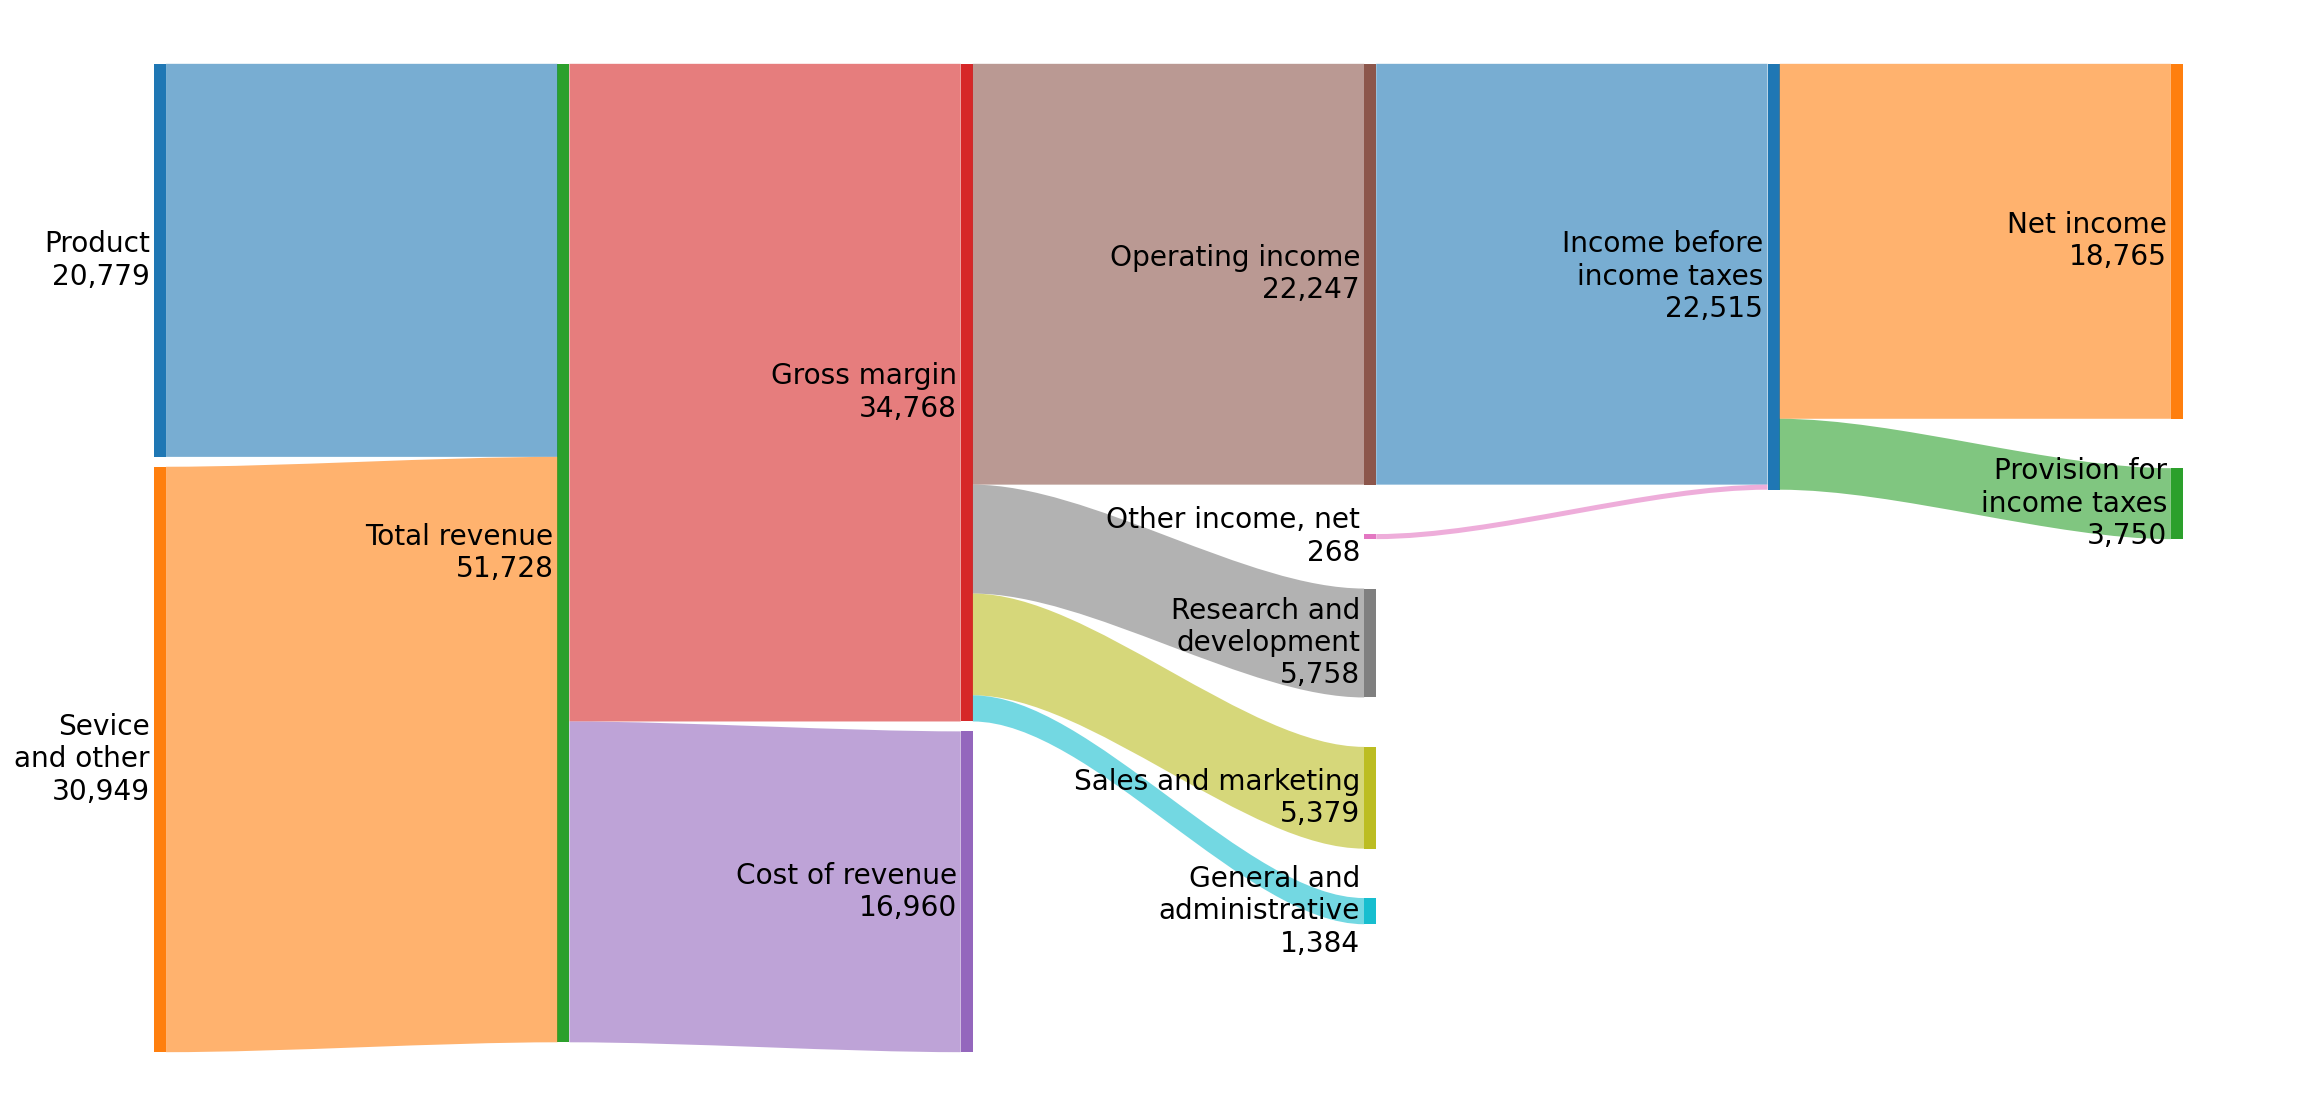

In [98]:
plt.figure(figsize=(20, 10), dpi=144)
nodes = [
    [('Product', 20779), ('Sevice\nand other', 30949)],
    [('Total revenue', 51728)],
    [('Gross margin', 34768), ('Cost of revenue', 16960)],
    [('Operating income', 22247), ('Other income, net', 268), ('Research and\ndevelopment', 5758), ('Sales and marketing', 5379), ('General and\nadministrative', 1384)],
    [('Income before\nincome taxes', 22515)],
    [('Net income', 18765), ('Provision for\nincome taxes', 3750)]
]
flows = [
    ('Product', 'Total revenue', 20779, {'flow_color_mode': 'source'}),
    ('Sevice\nand other', 'Total revenue', 30949, {'flow_color_mode': 'source'}),
    ('Total revenue', 'Gross margin', 34768),
    ('Total revenue', 'Cost of revenue', 16960),
    ('Gross margin', 'Operating income', 22247),
    ('Gross margin', 'Research and\ndevelopment', 5758), 
    ('Gross margin', 'Sales and marketing', 5379), 
    ('Gross margin', 'General and\nadministrative', 1384),
    ('Operating income', 'Income before\nincome taxes', 22247),
    ('Other income, net', 'Income before\nincome taxes', 268, {'flow_color_mode': 'source'}),
    ('Income before\nincome taxes', 'Net income', 18765), 
    ('Income before\nincome taxes', 'Provision for\nincome taxes', 3750),
]

s = Sankey(
    flows=flows,
    nodes=nodes,
)
s.draw()
plt.show()